In [5]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib


# Simulate cortical surface with s/M/EEG forward solutions

Cortical surface with subcortical regions, sEEG, EEG & MEG, using a stochastic
integration.

In [10]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.projections import ProjectionMatrix


oscillator = models.Generic2dOscillator(a=0.1, tau=2.0)

white_matter = connectivity.Connectivity.from_file('connectivity_192.zip')
white_matter.speed = numpy.array([4.0])
white_matter_coupling = coupling.Difference(a=0.014)

heunint = integrators.HeunStochastic(
    dt=2**-4,
    noise=noise.Additive(nsig=numpy.array([2 ** -5, ]))
)

fsamp = 1e3/1024.0 # 1024 Hz
mons = (
    monitors.EEG(load_default=True, period=fsamp),
    monitors.MEG(load_default=True, period=fsamp),
    monitors.iEEG(load_default=True, period=fsamp),
    monitors.ProgressLogger(period=100.0),
)

local_coupling_strength = numpy.array([2 ** -10])
default_cortex = Cortex(
    region_mapping_data=RegionMapping.from_file('regionMapping_16k_192.txt'),
    load_default=True)
default_cortex.coupling_strength = local_coupling_strength

sim = simulator.Simulator(
    model=oscillator,
    connectivity=white_matter,
    coupling=white_matter_coupling,
    integrator=heunint,
    monitors=mons,
    surface=default_cortex,
    simulation_length=1000.0
).configure()

eeg, meg, seeg, _ = sim.run()

WARNING  File 'hemispheres' not found in ZIP.
   INFO  step 1 time 0.0001 s
   INFO  step 1601 time 0.1001 s
   INFO  step 3201 time 0.2001 s
   INFO  step 4801 time 0.3001 s
   INFO  step 6401 time 0.4001 s
   INFO  step 8001 time 0.5001 s
   INFO  step 9601 time 0.6001 s
   INFO  step 11201 time 0.7001 s
   INFO  step 12801 time 0.8001 s
   INFO  step 14401 time 0.9001 s


<IPython.core.display.Javascript object>


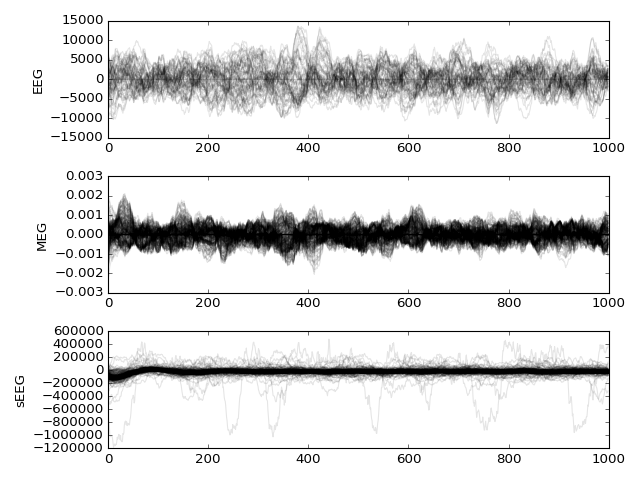

In [11]:
figure()

for i, mon in enumerate((eeg, meg, seeg)):
    subplot(3, 1, i + 1)
    time, data = mon
    plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
    ylabel(['EEG', 'MEG', 'sEEG'][i])

tight_layout()